## Problem Statement

Employee turn-over (also known as "employee churn") is a costly problem for companies. The true cost of replacing an employee can often be quite large. A study by the Center for American Progress found that companies typically pay about one-fifth of an employee’s salary to replace that employee, and the cost can significantly increase if executives or highest-paid employees are to be replaced. In other words, the cost of replacing employees for most employers remains significant. This is due to the amount of time spent to interview and find a replacement, sign-on bonuses, and the loss of productivity for several months while the new employee gets accustomed to the new role.

In this study, given that we have data on former employees, this is a supervised classification problem where the label is a binary variable, 0 (active employee), 1 (former employee). In this study, our target variable Y is the probability of an employee leaving the company.

### Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate, validation_curve

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_regression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### 1. Data

In [115]:
data = pd.read_csv('HR_Employee_Attrition.csv')

data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


As per checking, EmployeeNumber seems to be an identifier.

Based on the description of the dataset from the creator, the following variables are ordinal: </br> Education, EnvironmentSatisfaction, JobInvolvement, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, and WorkLifeBalance

After checking the dataset, JobLevel and StockOptionLevel should also be ordinal.

### 2. Data Preparation

In [116]:
# Drop identifier and check for missing values
data = data.drop('EmployeeNumber', axis = 1)

# quick overview of the variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [4]:
# Check for variables with constant value then remove if there exist

val = data.apply(lambda x: len(x.unique()))
val[val==1].index

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

In [5]:
data.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)

### 3. Data Visualization

#### Nominal Variable

In [6]:
# get categorical variables
nominal_df = data.select_dtypes(include=['object'])
nominal_df.head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No


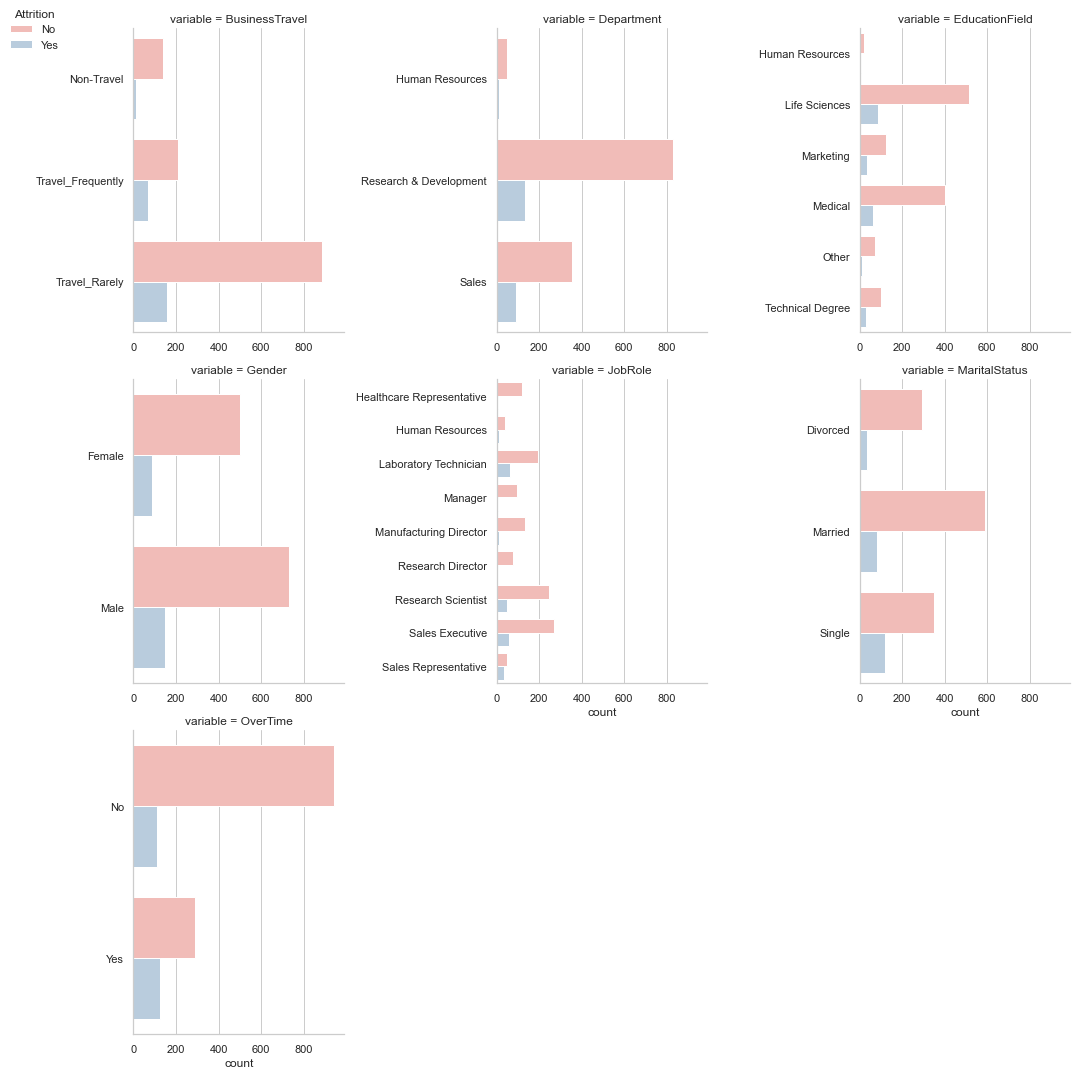

In [134]:
# count of category per variable
val = nominal_df.melt(value_name = 'category', id_vars = 'Attrition')\
    .groupby(['variable', 'category', 'Attrition']).size().to_frame('count').reset_index()

g = sns.catplot(data=val, x='count', y='category', col='variable', hue = 'Attrition', kind='bar', col_wrap=3,
    orient = 'h', palette='Pastel1', sharey = False)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left')
g.set(ylabel = None)

#### Ordinal Variable

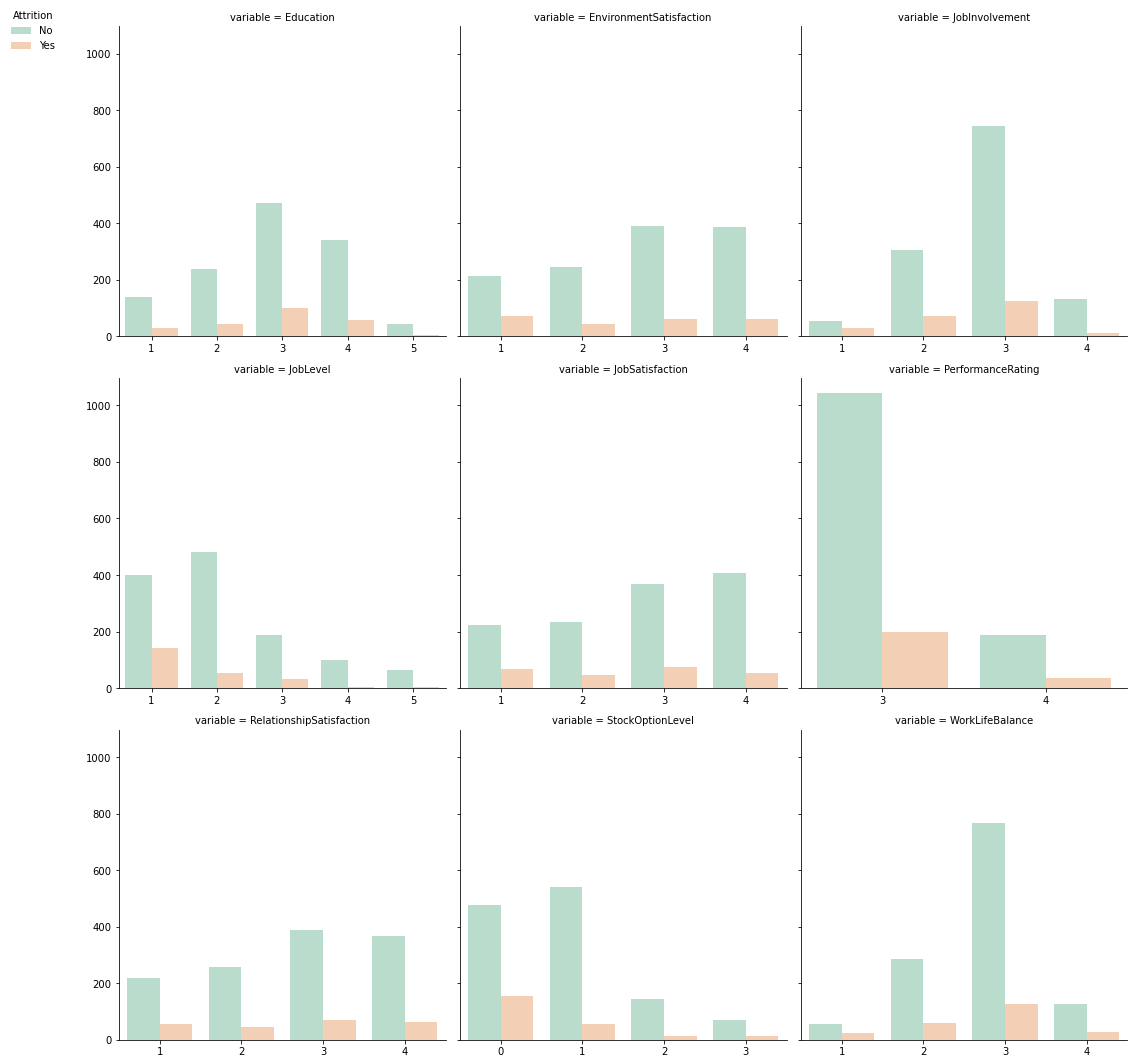

In [8]:
ordinal = ['Education', 'EnvironmentSatisfaction', 'JobLevel', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 
           'RelationshipSatisfaction', 'WorkLifeBalance', 'StockOptionLevel']
ordinal_df = data[ordinal]

val = pd.concat([data['Attrition'], ordinal_df], axis = 1)\
    .melt(value_name = 'category', id_vars = 'Attrition')\
    .groupby(['variable', 'category', 'Attrition']).size().to_frame('count').reset_index()

g = sns.catplot(data=val, x='category', y='count', col='variable', hue = 'Attrition', kind='bar', col_wrap=3, 
                palette='Pastel2', sharex = False)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left', bbox_to_anchor=(-0.05, 1))
g.set(ylabel = None, xlabel = None)

#### Numerical Variables

In [9]:
numeric = data.describe().columns
num_df = data[numeric].reset_index(drop = True).drop(ordinal, axis = 1)
num_df.describe()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,65.891156,6502.931293,14313.103401,2.693197,15.209524,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,20.329428,4707.956783,7117.786044,2.498009,3.659938,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,48.000000,2911.000000,8047.000000,1.000000,12.000000,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,66.000000,4919.000000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,83.750000,8379.000000,20461.500000,4.000000,18.000000,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


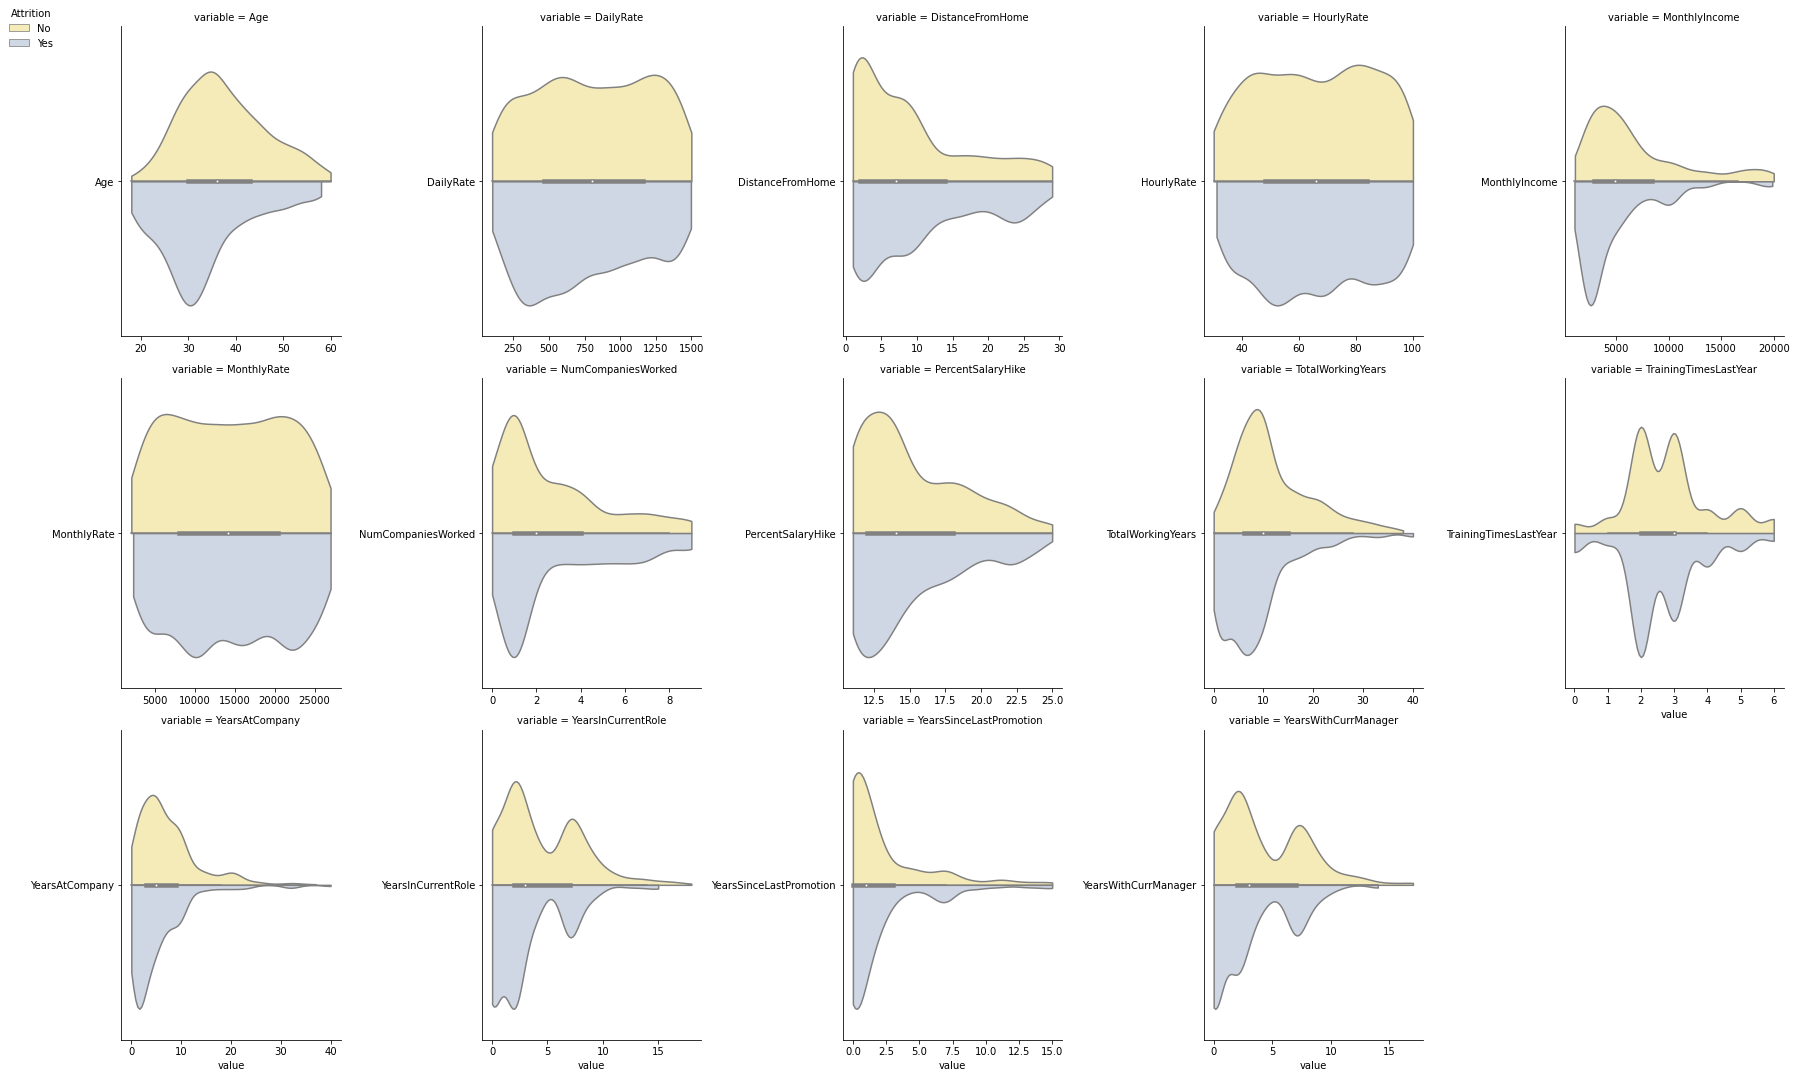

In [10]:
val = pd.concat([data['Attrition'], num_df], axis = 1)\
    .melt(value_name = 'value', id_vars = 'Attrition')

# compare the distribution of numeric features based on attrition
g = sns.catplot(data=val, x='value', y='variable', hue='Attrition', hue_order = ['No', 'Yes'],
    kind='violin', bw=.25, cut=0, split=True, col = 'variable', col_wrap = 5, palette = 'Pastel2_r',
    sharey = False, sharex = False)

g.set(ylabel=None)
sns.move_legend(g, 'upper left')

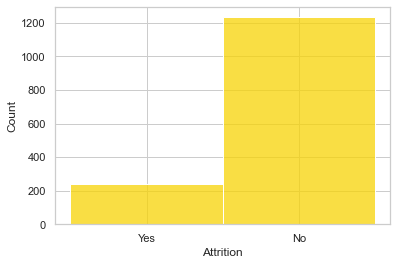

In [125]:
# show that is an unbalanced dataset

sns.set(style="whitegrid")
att = sns.histplot(data=data, x="Attrition", color='#f7d305')

<AxesSubplot:>

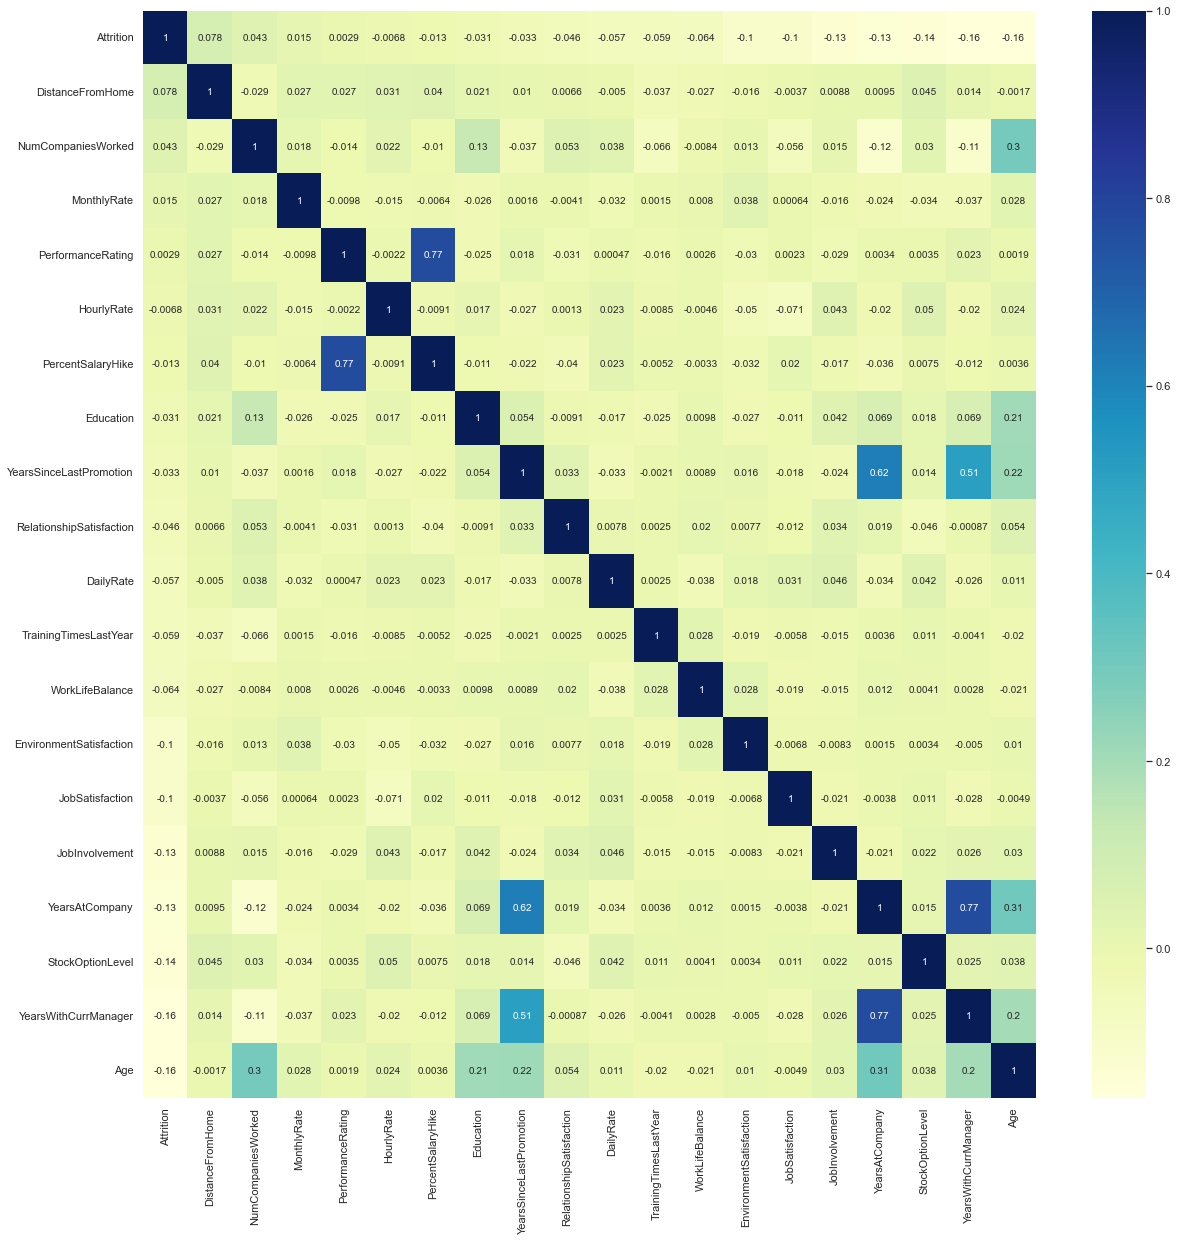

In [12]:
# Corr with the terget varible

data['Attrition'] = data['Attrition'].factorize(['No','Yes'])[0]

col = data.corr().nlargest(20, "Attrition").Attrition.index
plt.figure(figsize=(20, 20))
sns.heatmap(data[col].corr(), annot=True, cmap="YlGnBu", annot_kws={"size":10})

In [13]:
#input_df.drop(['JobLevel', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole'], axis = 1, inplace = True)

### 4. Data Preprocess 

In [14]:
# checking the values of all the features using value counts

categoricals = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
                'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 
                'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

for feature in categoricals:
    print(f"Values Counts for [{feature}]")
    print(data[feature].value_counts())
    print("\n\n")

Values Counts for [BusinessTravel]
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64



Values Counts for [Department]
Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64



Values Counts for [Education]
3    572
4    398
2    282
1    170
5     48
Name: Education, dtype: int64



Values Counts for [EducationField]
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64



Values Counts for [EnvironmentSatisfaction]
3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64



Values Counts for [Gender]
Male      882
Female    588
Name: Gender, dtype: int64



Values Counts for [JobInvolvement]
3    868
2    375
4    144
1     83
Name: JobInvolvement, dtype: int64



Values Counts for [JobLevel]
1    543
2    534
3

Categorical variables that are Binary- Gender, OverTime, PerformanceRating.

Performance Rating has only two values- 3 & 4. We can modify the values such that 0 replaces 3 and 1 replaces 4.

Attrition feature also needs to be binarised.

In [15]:
data['OverTime'] = data['OverTime'].map({'Yes': 1, 'No': 0})
data['OverTime'].value_counts()

0    1054
1     416
Name: OverTime, dtype: int64

In [16]:
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['Gender'].value_counts()

1    882
0    588
Name: Gender, dtype: int64

In [17]:
data['PerformanceRating'] = data['PerformanceRating'].map({3: 0, 4: 1})
data['PerformanceRating'].value_counts()

0    1244
1     226
Name: PerformanceRating, dtype: int64

In [18]:
#data.corr()['Attrition'].sort_values(ascending=False)
data['Attrition'] = data['Attrition'].factorize(['No','Yes'])[0]

Nominal Categorical Variables that need to be dummy encoded: BusinessTravel, Department, EducationField, JobRole, MaritalStatus

Ordinal Categoricals do not need to be dummy encoded since we would lose the ordered nature of the variables which is important in this case. We assume that the differences in levels are more or less similar and that we can treat them as continuous.

In [19]:
nominals = ['BusinessTravel','Department','EducationField','JobRole','MaritalStatus']
data_ohe = pd.get_dummies(data, columns = nominals)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int64
 2   DailyRate                          1470 non-null   int64
 3   DistanceFromHome                   1470 non-null   int64
 4   Education                          1470 non-null   int64
 5   EnvironmentSatisfaction            1470 non-null   int64
 6   Gender                             1470 non-null   int64
 7   HourlyRate                         1470 non-null   int64
 8   JobInvolvement                     1470 non-null   int64
 9   JobLevel                           1470 non-null   int64
 10  JobSatisfaction                    1470 non-null   int64
 11  MonthlyIncome                      1470 non-null   int64
 12  MonthlyRate         

In [20]:
# Scaling

scaler = MinMaxScaler()
model = scaler.fit(data_ohe)
scaled = model.transform(data_ohe)

data_scaled = pd.DataFrame(scaled, index=data_ohe.index, columns=data_ohe.columns)
data_scaled.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.547619,1.0,0.715820,0.000000,0.25,0.333333,0.0,0.914286,0.666667,0.25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.738095,0.0,0.126700,0.250000,0.00,0.666667,1.0,0.442857,0.333333,0.25,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.452381,1.0,0.909807,0.035714,0.25,1.000000,1.0,0.885714,0.333333,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.357143,0.0,0.923407,0.071429,0.75,1.000000,0.0,0.371429,0.666667,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.214286,0.0,0.350036,0.035714,0.00,0.000000,1.0,0.142857,0.666667,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


What is Collinearity?

Is a phenomenon in which one feature variable in a regression model is highly linearly correlated with another feature variable.

Source: https://medium.com/future-vision/collinearity-what-it-means-why-its-bad-and-how-does-it-affect-other-models-94e1db984168#:~:text=1%20In%20statistics%2C%20multicollinearity%20

In [21]:
# Threshold for removing correlated variables
threshold = 0.85

# Absolute value correlation matrix
corr_matrix = data_scaled.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

data_nocorr = data_scaled.drop(columns = to_drop)
to_drop

There are 3 columns to remove :


['MonthlyIncome', 'Department_Sales', 'JobRole_Human Resources']

In [22]:
data_nocorr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1470 non-null   float64
 1   Attrition                          1470 non-null   float64
 2   DailyRate                          1470 non-null   float64
 3   DistanceFromHome                   1470 non-null   float64
 4   Education                          1470 non-null   float64
 5   EnvironmentSatisfaction            1470 non-null   float64
 6   Gender                             1470 non-null   float64
 7   HourlyRate                         1470 non-null   float64
 8   JobInvolvement                     1470 non-null   float64
 9   JobLevel                           1470 non-null   float64
 10  JobSatisfaction                    1470 non-null   float64
 11  MonthlyRate                        1470 non-null   float

### Spltting and Smote

In [23]:
def splitting_train_test_smote(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Balance the dataset with SMOTE 
    smt = SMOTETomek(random_state=42)
    X_train, y_train = smt.fit_resample(X_train, y_train)

    print("Number transactions X dataset: ", X_train.shape, X_test.shape)
    print("Number transactions y dataset: ", y_train.shape, y_test.shape)
    print('Resampled dataset shape %s' % Counter(y_train))
    
    return X_train, X_test, y_train, y_test

In [127]:
y = data_nocorr.Attrition
X = data_nocorr.drop(columns=['Attrition'])

X_train, X_test, y_train, y_test = splitting_train_test_smote(X, y)

Number transactions X dataset:  (1706, 46) (441, 46)
Number transactions y dataset:  (1706,) (441,)
Resampled dataset shape Counter({0.0: 853, 1.0: 853})


### 5. Analysis with all the Variables

In [25]:
# Defining a func to summarize the results of the classifiers

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        
def plot_features (model, data, color):
    importances = pd.DataFrame(data={
        'Attribute': data.columns,
        'Importance': model.coef_[0]
    })
    importances = importances.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize = (10,10))
    plt.bar(x=importances['Attribute'], height=importances['Importance'], color=color)
    plt.title('Feature importances obtained from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()
    
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Features Importances')
    plt.tight_layout()
    plt.xticks(rotation='vertical')
    plt.show()
    if save:
        plt.savefig('importances.png')
        
def plot_decision_tree(model, feature_names, depth):
    tree = plot_tree(model, max_depth=depth, feature_names = feature_names,
                     rounded = True, proportion = True, precision = 2, filled = True, fontsize=10)
    return tree

In [26]:
# LOGIT

lr1 = LogisticRegression(solver='liblinear')
lr1.fit(X_train, y_train)

print_score(lr1, X_train, y_train, X_test, y_test, train=True)
print_score(lr1, X_train, y_train, X_test, y_test, train=False)

lr1_acc =  lr1.score(X_test, y_test)
allvar_acc = [lr1_acc]

Train Result:
Accuracy Score: 83.29%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.848894    0.818386  0.832943     0.833640      0.833640
recall       0.810082    0.855803  0.832943     0.832943      0.832943
f1-score     0.829034    0.836676  0.832943     0.832855      0.832855
support    853.000000  853.000000  0.832943  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[691 162]
 [123 730]]

Test Result:
Accuracy Score: 76.87%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.929012   0.324786  0.768707    0.626899      0.845435
recall       0.792105   0.622951  0.768707    0.707528      0.768707
f1-score     0.855114   0.426966  0.768707    0.641040      0.795891
support    380.000000  61.000000  0.768707  441.000000    441.

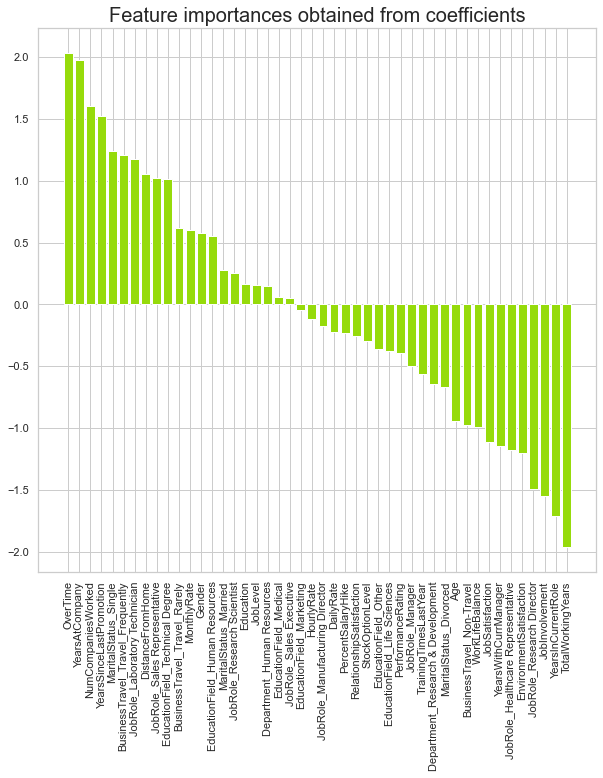

In [128]:
plot_features(lr1, X_train, '#96db0b')

In [28]:
# LDA

lda1 = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda1.fit(X_train, y_train)

print_score(lda1, X_train, y_train, X_test, y_test, train=True)
print_score(lda1, X_train, y_train, X_test, y_test, train=False)

lda1_acc =  lda1.score(X_test, y_test)
allvar_acc.append(lda1_acc)

Train Result:
Accuracy Score: 82.06%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.847522    0.797606  0.820633     0.822564      0.822564
recall       0.781946    0.859320  0.820633     0.820633      0.820633
f1-score     0.813415    0.827314  0.820633     0.820364      0.820364
support    853.000000  853.000000  0.820633  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[667 186]
 [120 733]]

Test Result:
Accuracy Score: 75.96%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.939103   0.325581  0.759637    0.632342      0.854239
recall       0.771053   0.688525  0.759637    0.729789      0.759637
f1-score     0.846821   0.442105  0.759637    0.644463      0.790840
support    380.000000  61.000000  0.759637  441.000000    441.

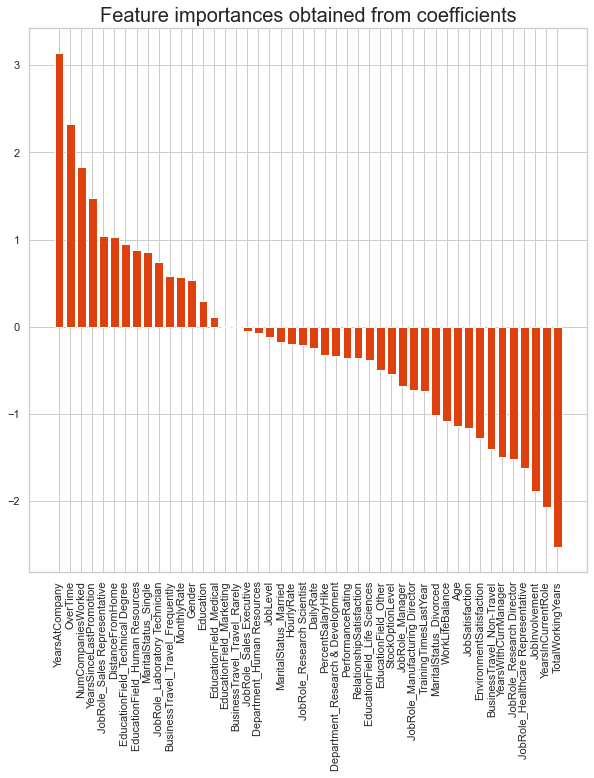

In [130]:
plot_features(lda1, X_train, '#de410d')

In [30]:
# Naive Bayes
nb1 = GaussianNB()
nb1.fit(X_train, y_train)

print_score(nb1, X_train, y_train, X_test, y_test, train=True)
print_score(nb1, X_train, y_train, X_test, y_test, train=False)

nb1_acc =  nb1.score(X_test, y_test)
allvar_acc.append(nb1_acc)

Train Result:
Accuracy Score: 71.75%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.797753    0.671283  0.717468     0.734518      0.734518
recall       0.582649    0.852286  0.717468     0.717468      0.717468
f1-score     0.673442    0.751033  0.717468     0.712237      0.712237
support    853.000000  853.000000  0.717468  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[497 356]
 [126 727]]

Test Result:
Accuracy Score: 56.01%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.915179   0.193548  0.560091    0.554363      0.815361
recall       0.539474   0.688525  0.560091    0.613999      0.560091
f1-score     0.678808   0.302158  0.560091    0.490483      0.626709
support    380.000000  61.000000  0.560091  441.000000    441.

overfittig??

Precision can be defined as the percentage of correctly predicted positive outcomes out of all the predicted positive outcomes. It can be given as the ratio of true positives (TP) to the sum of true and false positives (TP + FP).

So, Precision identifies the proportion of correctly predicted positive outcome. It is more concerned with the positive class than the negative class.

Recall can be defined as the percentage of correctly predicted positive outcomes out of all the actual positive outcomes. It can be given as the ratio of true positives (TP) to the sum of true positives and false negatives (TP + FN). Recall is also called Sensitivity.

Recall identifies the proportion of correctly predicted actual positives.

In [31]:
# Multinomial NB
mnb1 = MultinomialNB()
mnb1.fit(X_train, y_train)

print_score(mnb1, X_train, y_train, X_test, y_test, train=True)
print_score(mnb1, X_train, y_train, X_test, y_test, train=False)

mnb1_acc = mnb1.score(X_test, y_test)
allvar_acc.append(mnb1_acc)

Train Result:
Accuracy Score: 77.08%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.795396    0.750000  0.770809     0.772698      0.772698
recall       0.729191    0.812427  0.770809     0.770809      0.770809
f1-score     0.760856    0.779966  0.770809     0.770411      0.770411
support    853.000000  853.000000  0.770809  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[622 231]
 [160 693]]

Test Result:
Accuracy Score: 67.35%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.924460   0.245399  0.673469    0.584930      0.830531
recall       0.676316   0.655738  0.673469    0.666027      0.673469
f1-score     0.781155   0.357143  0.673469    0.569149      0.722505
support    380.000000  61.000000  0.673469  441.000000    441.

In [32]:
# Complement NB
cnb1 = ComplementNB()
cnb1.fit(X_train, y_train)

print_score(cnb1, X_train, y_train, X_test, y_test, train=True)
print_score(cnb1, X_train, y_train, X_test, y_test, train=False)

cnb1_acc = cnb1.score(X_test, y_test)
allvar_acc.append(cnb1_acc)

Train Result:
Accuracy Score: 77.08%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.795396    0.750000  0.770809     0.772698      0.772698
recall       0.729191    0.812427  0.770809     0.770809      0.770809
f1-score     0.760856    0.779966  0.770809     0.770411      0.770411
support    853.000000  853.000000  0.770809  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[622 231]
 [160 693]]

Test Result:
Accuracy Score: 67.35%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.924460   0.245399  0.673469    0.584930      0.830531
recall       0.676316   0.655738  0.673469    0.666027      0.673469
f1-score     0.781155   0.357143  0.673469    0.569149      0.722505
support    380.000000  61.000000  0.673469  441.000000    441.

In [33]:
# Bernouilli NB
bnb1 = BernoulliNB()
bnb1.fit(X_train, y_train)

print_score(bnb1, X_train, y_train, X_test, y_test, train=True)
print_score(bnb1, X_train, y_train, X_test, y_test, train=False)

bnb1_acc =  bnb1.score(X_test, y_test)
allvar_acc.append(bnb1_acc)

Train Result:
Accuracy Score: 79.84%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.794220    0.802616  0.798359     0.798418      0.798418
recall       0.805393    0.791325  0.798359     0.798359      0.798359
f1-score     0.799767    0.796930  0.798359     0.798349      0.798349
support    853.000000  853.000000  0.798359  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[687 166]
 [178 675]]

Test Result:
Accuracy Score: 72.11%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.910543   0.257812  0.721088    0.584178      0.820256
recall       0.750000   0.540984  0.721088    0.645492      0.721088
f1-score     0.822511   0.349206  0.721088    0.585859      0.757042
support    380.000000  61.000000  0.721088  441.000000    441.

In [34]:
# AdaBoost classifier
#abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)
#abc.fit(X_train, y_train)
#
#abc_params = {"learning_rate": [0.05, 0.1, 0.25, 0.5, 0.75, 1],
#              #"max_depth": [1,2,3],
#              "n_estimators": [10,20,30,40,50],
#              #"subsample": [0.5,0.6,0.7,0.8,0.9],
#              #"min_samples_split": range(10,10),
#              #"min_samples_leaf" : range(15,25),
#              #"max_features":[7,10,13]
#             }
#
#abc_best_grid = GridSearchCV(abc, abc_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
#abc_best_grid.best_params_

In [35]:
abc1 = AdaBoostClassifier(n_estimators=200, learning_rate=0.75, random_state=42)
abc1.fit(X_train, y_train)

print_score(abc1, X_train, y_train, X_test, y_test, train=True)
print_score(abc1, X_train, y_train, X_test, y_test, train=False) # 94.84    87.3

abc1_acc =  abc1.score(X_test, y_test)
allvar_acc.append(abc1_acc)

Train Result:
Accuracy Score: 94.84%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.934166    0.963636  0.948417     0.948901      0.948901
recall       0.964830    0.932005  0.948417     0.948417      0.948417
f1-score     0.949250    0.947557  0.948417     0.948403      0.948403
support    853.000000  853.000000  0.948417  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[823  30]
 [ 58 795]]

Test Result:
Accuracy Score: 87.30%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.919689   0.545455  0.873016    0.732572      0.867924
recall       0.934211   0.491803  0.873016    0.713007      0.873016
f1-score     0.926893   0.517241  0.873016    0.722067      0.870229
support    380.000000  61.000000  0.873016  441.000000    441.

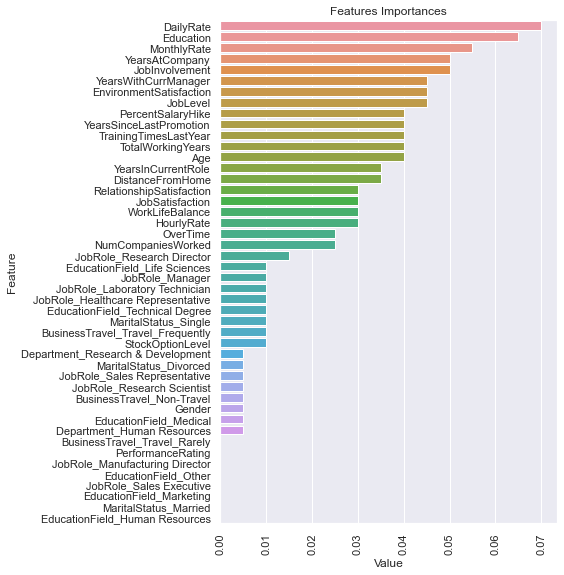

In [36]:
plot_importance(abc1, X)

In [37]:
#bag1 = BaggingClassifier(random_state=42)
#bag1.fit(X_train, y_train)
#
#bag_params = {'n_estimators': [100, 200, 250, 300, 350],
#              'max_features': [0.90, 0.95, 1.0],
#              'bootstrap': [True, False],
#              'bootstrap_features': [True, False],}
#
#bag_best_grid = GridSearchCV(bag1, bag_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
#bag_best_grid.best_params_

In [38]:
bag1 = BaggingClassifier(n_estimators=300, max_features=1.0, bootstrap_features=True, bootstrap=False, random_state=42)
bag1.fit(X_train, y_train)

print_score(bag1, X_train, y_train, X_test, y_test, train=True)
print_score(bag1, X_train, y_train, X_test, y_test, train=False) # 100   87.98

bag1_acc =  bag1.score(X_test, y_test)
allvar_acc.append(bag1_acc)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
             0.0    1.0  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  853.0       1.0     1706.0        1706.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 853]]

Test Result:
Accuracy Score: 87.98%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.884706   0.750000  0.879819    0.817353      0.866073
recall       0.989474   0.196721  0.879819    0.593097      0.879819
f1-score     0.934161   0.311688  0.879819    0.622925      0.848060
support    380.000000  61.000000  0.879819  441.000000    441.000000
_______________________________________________
Conf

You need to understand that bagging decreases variance, while boosting decreases bias. Also, to be noted that under-fitting means that the model has low variance and high bias and vice versa for overfitting. So, boosting is more vulnerable to overfitting than bagging.

Bagging works best with strong and complex models(for example, fully developed decision trees). However, don't let that fool you to thinking that similar to a decision tree, bagging also overfits the model. Instead, bagging reduces overfitting since a lot of the sample training data are repeated and used to create base estimators. With a lot of equally likely training data, bagging is not very susceptible to overfitting with noisy data, therefore reduces variance. However, the downside is that this leads to an increase in bias.

In [39]:
bag1.estimators_

[DecisionTreeClassifier(random_state=1952926171),
 DecisionTreeClassifier(random_state=1761383086),
 DecisionTreeClassifier(random_state=1449071958),
 DecisionTreeClassifier(random_state=1910541088),
 DecisionTreeClassifier(random_state=1341730541),
 DecisionTreeClassifier(random_state=1286572245),
 DecisionTreeClassifier(random_state=1005142668),
 DecisionTreeClassifier(random_state=502852014),
 DecisionTreeClassifier(random_state=186414760),
 DecisionTreeClassifier(random_state=1956263048),
 DecisionTreeClassifier(random_state=15592051),
 DecisionTreeClassifier(random_state=1628376228),
 DecisionTreeClassifier(random_state=1638437331),
 DecisionTreeClassifier(random_state=116435712),
 DecisionTreeClassifier(random_state=588556688),
 DecisionTreeClassifier(random_state=358068376),
 DecisionTreeClassifier(random_state=67998415),
 DecisionTreeClassifier(random_state=825108120),
 DecisionTreeClassifier(random_state=1237545031),
 DecisionTreeClassifier(random_state=1708477288),
 DecisionT

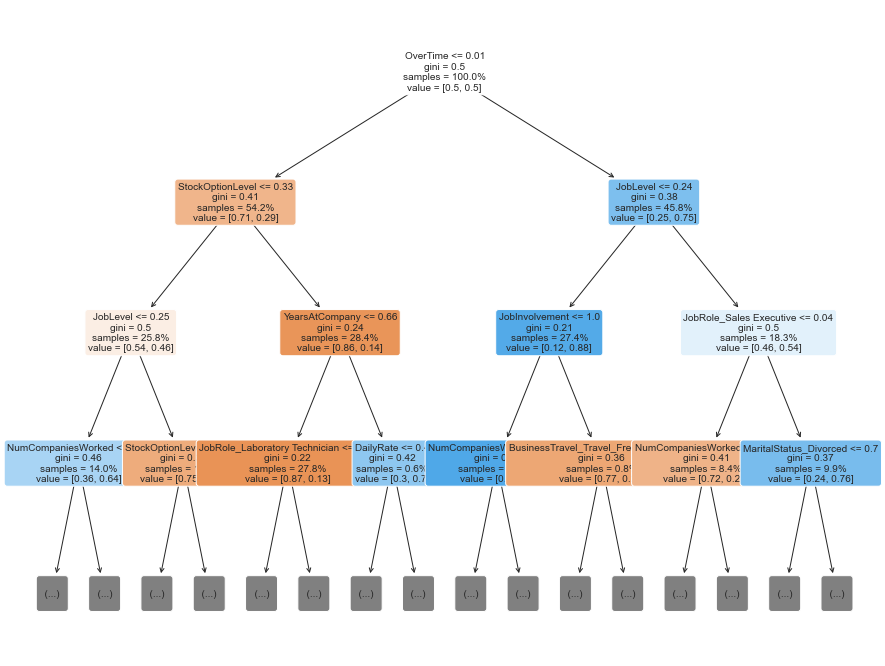

In [40]:
tree1 = DecisionTreeClassifier(random_state=1952926171)
tree1.fit(X_train, y_train)

fig = plt.figure(figsize=(15, 12))
plot_decision_tree(tree1, X.columns, 3)
plt.show()

In [41]:
# Creting a table to compare the algo

acc_df = pd.DataFrame(allvar_acc, 
                      columns = ['All Variables'],
                      index = ['Logistic Regression', 'Linear Disciriminant Analysis', 'Naive Bayes', 
                               'Multinomial NB', 'Complement NB', 'Bernouilli NB', 
                               'AdaBoost', 'Bagging']) 
acc_df

,All Variables
Logistic Regression,0.768707
Linear Disciriminant Analysis,0.759637
Naive Bayes,0.560091
Multinomial NB,0.673469
Complement NB,0.673469
Bernouilli NB,0.721088
AdaBoost,0.873016
Bagging,0.879819


## 6. Univariate Filter Feature Subset Selection

### 6.1 Chi-squared

In [42]:
BestFeatures = SelectKBest(score_func=chi2, k=5)
fit = BestFeatures.fit(X, y)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

#concatenating two dataframes for better visualization
f_Scores = pd.concat([df_columns,df_scores],axis=1)      
f_Scores.columns = ['Specs','Score']  

print(f_Scores.nlargest(5,'Score'))      

X_kbest = BestFeatures.fit_transform(X, y)

print()
print('Original number of features:', X.shape)
print('Reduced number of features:', X_kbest.shape)

                               Specs      Score
12                          OverTime  63.845067
42      JobRole_Sales Representative  34.290268
45              MaritalStatus_Single  30.771669
25  BusinessTravel_Travel_Frequently  15.816623
8                           JobLevel  12.094895

Original number of features: (1470, 46)
Reduced number of features: (1470, 5)


In [43]:
# New train and test with only the selected 5 features

X_chi = X[['OverTime', 'JobRole_Sales Representative', 'MaritalStatus_Single', 'BusinessTravel_Travel_Frequently', 'JobLevel']]
X_train, X_test, y_train, y_test = splitting_train_test_smote(X_chi, y)

Number transactions X dataset:  (1706, 5) (441, 5)
Number transactions y dataset:  (1706,) (441,)
Resampled dataset shape Counter({0.0: 853, 1.0: 853})


In [44]:
# LOGIT
# 5 feat : accu = 67.12

lr2 = LogisticRegression(solver='liblinear')
lr2.fit(X_train, y_train)

print_score(lr2, X_train, y_train, X_test, y_test, train=True)
print_score(lr2, X_train, y_train, X_test, y_test, train=False)

lr2_acc = lr2.score(X_test, y_test)

Train Result:
Accuracy Score: 72.80%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.738650    0.718294  0.728019     0.728472      0.728472
recall       0.705744    0.750293  0.728019     0.728019      0.728019
f1-score     0.721823    0.733945  0.728019     0.727884      0.727884
support    853.000000  853.000000  0.728019  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[602 251]
 [213 640]]

Test Result:
Accuracy Score: 67.12%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.918149   0.237500  0.671202    0.577825      0.824001
recall       0.678947   0.622951  0.671202    0.650949      0.671202
f1-score     0.780635   0.343891  0.671202    0.562263      0.720224
support    380.000000  61.000000  0.671202  441.000000    441.

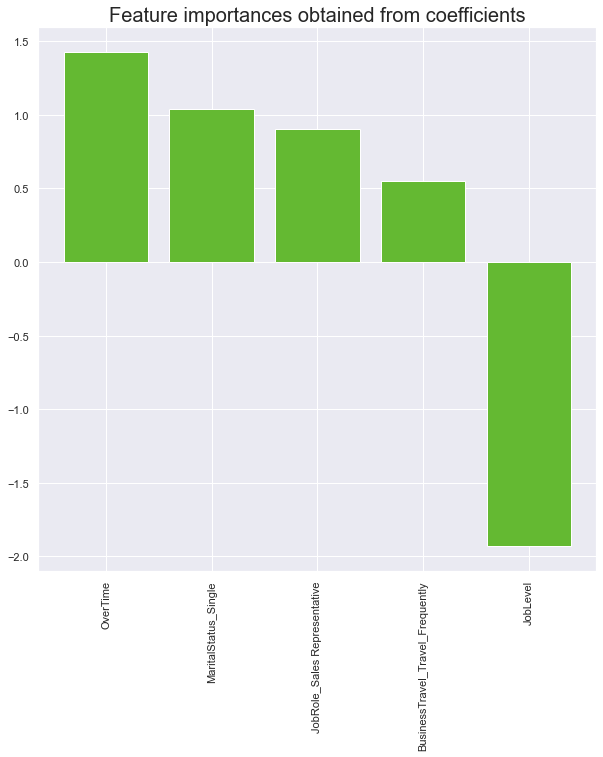

In [45]:
plot_features(lr2, X_train, '#64b932')

In [46]:
# LDA
# 5 feat : accu = 67.12

lda2 = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda2.fit(X_train, y_train)

print_score(lda2, X_train, y_train, X_test, y_test, train=True)
print_score(lda2, X_train, y_train, X_test, y_test, train=False)
lda2_acc = lda2.score(X_test, y_test)

Train Result:
Accuracy Score: 72.74%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.737745    0.717978  0.727433     0.727861      0.727861
recall       0.705744    0.749121  0.727433     0.727433      0.727433
f1-score     0.721390    0.733219  0.727433     0.727304      0.727304
support    853.000000  853.000000  0.727433  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[602 251]
 [214 639]]

Test Result:
Accuracy Score: 67.12%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.918149   0.237500  0.671202    0.577825      0.824001
recall       0.678947   0.622951  0.671202    0.650949      0.671202
f1-score     0.780635   0.343891  0.671202    0.562263      0.720224
support    380.000000  61.000000  0.671202  441.000000    441.

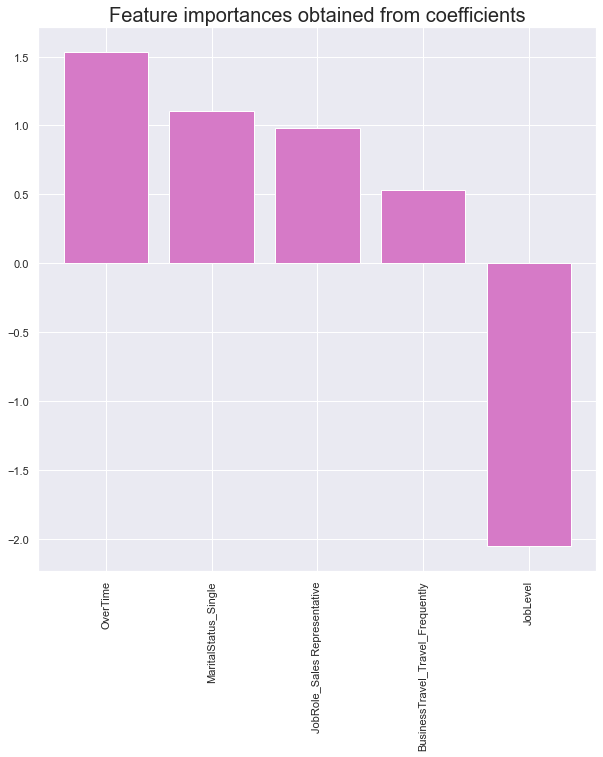

In [47]:
plot_features(lda2, X_train, '#d67ac7')

In [48]:
# NB
# 5 feat : accu = 79.82

nb2 = GaussianNB()
nb2.fit(X_train, y_train)

print_score(nb2, X_train, y_train, X_test, y_test, train=True)
print_score(nb2, X_train, y_train, X_test, y_test, train=False)
nb2_acc = nb2.score(X_test, y_test)

Train Result:
Accuracy Score: 72.51%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.686770    0.783186  0.725088     0.734978      0.734978
recall       0.827667    0.622509  0.725088     0.725088      0.725088
f1-score     0.750665    0.693664  0.725088     0.722164      0.722164
support    853.000000  853.000000  0.725088  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[706 147]
 [322 531]]

Test Result:
Accuracy Score: 79.82%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.907563   0.333333  0.798186    0.620448      0.828134
recall       0.852632   0.459016  0.798186    0.655824      0.798186
f1-score     0.879240   0.386207  0.798186    0.632724      0.811043
support    380.000000  61.000000  0.798186  441.000000    441.

In [49]:
# Multinomial NB
# 10 feat : accu = 55.78
mnb2 = MultinomialNB()
mnb2.fit(X_train, y_train)

print_score(mnb2, X_train, y_train, X_test, y_test, train=True)
print_score(mnb2, X_train, y_train, X_test, y_test, train=False)
mnb2_acc = mnb2.score(X_test, y_test)

Train Result:
Accuracy Score: 71.04%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.711425    0.709452  0.710434     0.710438      0.710438
recall       0.708089    0.712778  0.710434     0.710434      0.710434
f1-score     0.709753    0.711111  0.710434     0.710432      0.710432
support    853.000000  853.000000  0.710434  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[604 249]
 [245 608]]

Test Result:
Accuracy Score: 69.16%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.909396   0.237762   0.69161    0.573579      0.816494
recall       0.713158   0.557377   0.69161    0.635267      0.691610
f1-score     0.799410   0.333333   0.69161    0.566372      0.734941
support    380.000000  61.000000   0.69161  441.000000    441.

In [50]:
cnb2 = ComplementNB()
cnb2.fit(X_train, y_train)

print_score(cnb2, X_train, y_train, X_test, y_test, train=True)
print_score(cnb2, X_train, y_train, X_test, y_test, train=False)
cnb2_acc = cnb2.score(X_test, y_test)

Train Result:
Accuracy Score: 71.04%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.711425    0.709452  0.710434     0.710438      0.710438
recall       0.708089    0.712778  0.710434     0.710434      0.710434
f1-score     0.709753    0.711111  0.710434     0.710432      0.710432
support    853.000000  853.000000  0.710434  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[604 249]
 [245 608]]

Test Result:
Accuracy Score: 69.16%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.909396   0.237762   0.69161    0.573579      0.816494
recall       0.713158   0.557377   0.69161    0.635267      0.691610
f1-score     0.799410   0.333333   0.69161    0.566372      0.734941
support    380.000000  61.000000   0.69161  441.000000    441.

In [51]:
bnb2 = BernoulliNB()
bnb2.fit(X_train, y_train)

print_score(bnb2, X_train, y_train, X_test, y_test, train=True)
print_score(bnb2, X_train, y_train, X_test, y_test, train=False)
bnb2_acc = bnb2.score(X_test, y_test)

Train Result:
Accuracy Score: 73.09%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.713203    0.751918   0.73095     0.732561      0.732561
recall       0.772567    0.689332   0.73095     0.730950      0.730950
f1-score     0.741699    0.719266   0.73095     0.730483      0.730483
support    853.000000  853.000000   0.73095  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[659 194]
 [265 588]]

Test Result:
Accuracy Score: 73.02%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.911672   0.266129  0.730159    0.588900      0.822379
recall       0.760526   0.540984  0.730159    0.650755      0.730159
f1-score     0.829268   0.356757  0.730159    0.593013      0.763910
support    380.000000  61.000000  0.730159  441.000000    441.

In [52]:
# AdaBoost classifier
#abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)
#abc.fit(X_train, y_train)
#
#abc_params = {"learning_rate": [0.05, 0.1, 0.25, 0.5, 0.75, 1],
#              #"max_depth": [1,2,3],
#              "n_estimators": [10,20,30,40,50],
#              #"subsample": [0.5,0.6,0.7,0.8,0.9],
#              #"min_samples_split": range(10,10),
#              #"min_samples_leaf" : range(15,25),
#              #"max_features":[7,10,13]
#             }
#
#abc_best_grid = GridSearchCV(abc, abc_params, cv=5, n_jobs=-1, verbose=True).fit(X_chi, y)
#abc_best_grid.best_params_

In [53]:
abc2 = AdaBoostClassifier(n_estimators=40, learning_rate=0.75, random_state=42)
abc2.fit(X_train, y_train)

print_score(abc2, X_train, y_train, X_test, y_test, train=True)
print_score(abc2, X_train, y_train, X_test, y_test, train=False)
abc2_acc = abc2.score(X_test, y_test)

Train Result:
Accuracy Score: 74.97%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.743707    0.756010  0.749707     0.749858      0.749858
recall       0.762016    0.737397  0.749707     0.749707      0.749707
f1-score     0.752750    0.746588  0.749707     0.749669      0.749669
support    853.000000  853.000000  0.749707  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[650 203]
 [224 629]]

Test Result:
Accuracy Score: 72.34%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.916129   0.267176  0.723356    0.591652      0.826364
recall       0.747368   0.573770  0.723356    0.660569      0.723356
f1-score     0.823188   0.364583  0.723356    0.593886      0.759753
support    380.000000  61.000000  0.723356  441.000000    441.

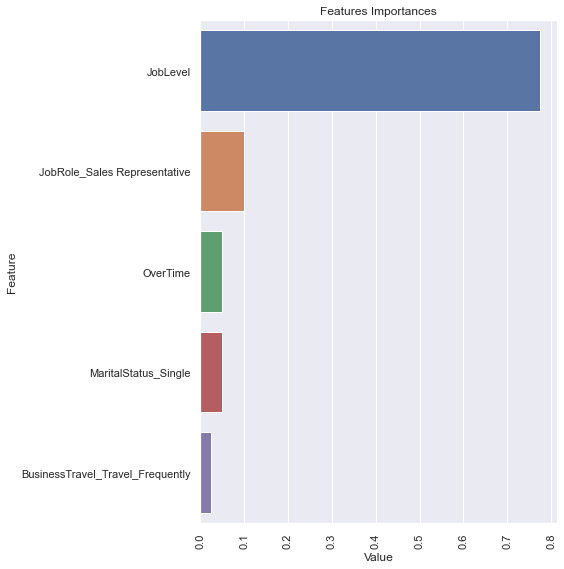

In [54]:
plot_importance(abc2, X_chi)

In [55]:
#bag2 = BaggingClassifier(random_state=42)
#bag2.fit(X_train, y_train)
#
#bag_params = {'n_estimators': [100, 200, 250, 300, 350],
#              'max_features': [0.90, 0.95, 1.0],
#              'bootstrap': [True, False],
#              'bootstrap_features': [True, False],}
#
#bag_best_grid = GridSearchCV(bag2, bag_params, cv=5, n_jobs=-1, verbose=True).fit(X_chi, y)
#bag_best_grid.best_params_

In [56]:
bag2 = BaggingClassifier(n_estimators=350, max_features=1.0, bootstrap_features=False, bootstrap=True, random_state=42)
bag2.fit(X_train, y_train)

print_score(bag2, X_train, y_train, X_test, y_test, train=True)
print_score(bag2, X_train, y_train, X_test, y_test, train=False)
bag2_acc = bag2.score(X_test, y_test)

Train Result:
Accuracy Score: 79.60%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.775956    0.819216  0.796014     0.797586      0.797586
recall       0.832356    0.759672  0.796014     0.796014      0.796014
f1-score     0.803167    0.788321  0.796014     0.795744      0.795744
support    853.000000  853.000000  0.796014  1706.000000   1706.000000
_______________________________________________
Confusion Matrix: 
 [[710 143]
 [205 648]]

Test Result:
Accuracy Score: 75.96%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.907738   0.285714  0.759637    0.596726      0.821699
recall       0.802632   0.491803  0.759637    0.647217      0.759637
f1-score     0.851955   0.361446  0.759637    0.606701      0.784107
support    380.000000  61.000000  0.759637  441.000000    441.

In [57]:
bag2.estimators_

[DecisionTreeClassifier(random_state=1952926171),
 DecisionTreeClassifier(random_state=1761383086),
 DecisionTreeClassifier(random_state=1449071958),
 DecisionTreeClassifier(random_state=1910541088),
 DecisionTreeClassifier(random_state=1341730541),
 DecisionTreeClassifier(random_state=1286572245),
 DecisionTreeClassifier(random_state=1005142668),
 DecisionTreeClassifier(random_state=502852014),
 DecisionTreeClassifier(random_state=186414760),
 DecisionTreeClassifier(random_state=1956263048),
 DecisionTreeClassifier(random_state=15592051),
 DecisionTreeClassifier(random_state=1628376228),
 DecisionTreeClassifier(random_state=1638437331),
 DecisionTreeClassifier(random_state=116435712),
 DecisionTreeClassifier(random_state=588556688),
 DecisionTreeClassifier(random_state=358068376),
 DecisionTreeClassifier(random_state=67998415),
 DecisionTreeClassifier(random_state=825108120),
 DecisionTreeClassifier(random_state=1237545031),
 DecisionTreeClassifier(random_state=1708477288),
 DecisionT

In [58]:
# Creting a table to compare the algo

chi_acc = [lr2_acc, lda2_acc, nb2_acc, mnb2_acc, cnb2_acc, bnb2_acc, abc2_acc, bag2_acc]
acc_df['ChiSquared'] = chi_acc
acc_df

,All Variables,ChiSquared
Logistic Regression,0.768707,0.671202
Linear Disciriminant Analysis,0.759637,0.671202
Naive Bayes,0.560091,0.798186
Multinomial NB,0.673469,0.691610
Complement NB,0.673469,0.691610
Bernouilli NB,0.721088,0.730159
AdaBoost,0.873016,0.723356
Bagging,0.879819,0.759637


### 7. Multivariate Feature Selection

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

In [59]:
# Redifine train and test
X_train, X_test, y_train, y_test = splitting_train_test_smote(X, y)

Number transactions X dataset:  (1706, 46) (441, 46)
Number transactions y dataset:  (1706,) (441,)
Resampled dataset shape Counter({0.0: 853, 1.0: 853})


In [60]:
discrete_features = X.dtypes == int

In [61]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

TotalWorkingYears                    0.045470
Age                                  0.035898
YearsAtCompany                       0.030770
JobRole_Sales Executive              0.030644
JobSatisfaction                      0.029686
EducationField_Other                 0.027030
JobInvolvement                       0.023839
JobRole_Research Director            0.023701
StockOptionLevel                     0.022967
YearsWithCurrManager                 0.019373
YearsInCurrentRole                   0.019372
EducationField_Life Sciences         0.018685
RelationshipSatisfaction             0.016726
JobRole_Sales Representative         0.015751
Department_Human Resources           0.015613
MaritalStatus_Single                 0.013964
NumCompaniesWorked                   0.012799
YearsSinceLastPromotion              0.011238
OverTime                             0.010961
TrainingTimesLastYear                0.009362
JobRole_Laboratory Technician        0.008491
EducationField_Technical Degree   

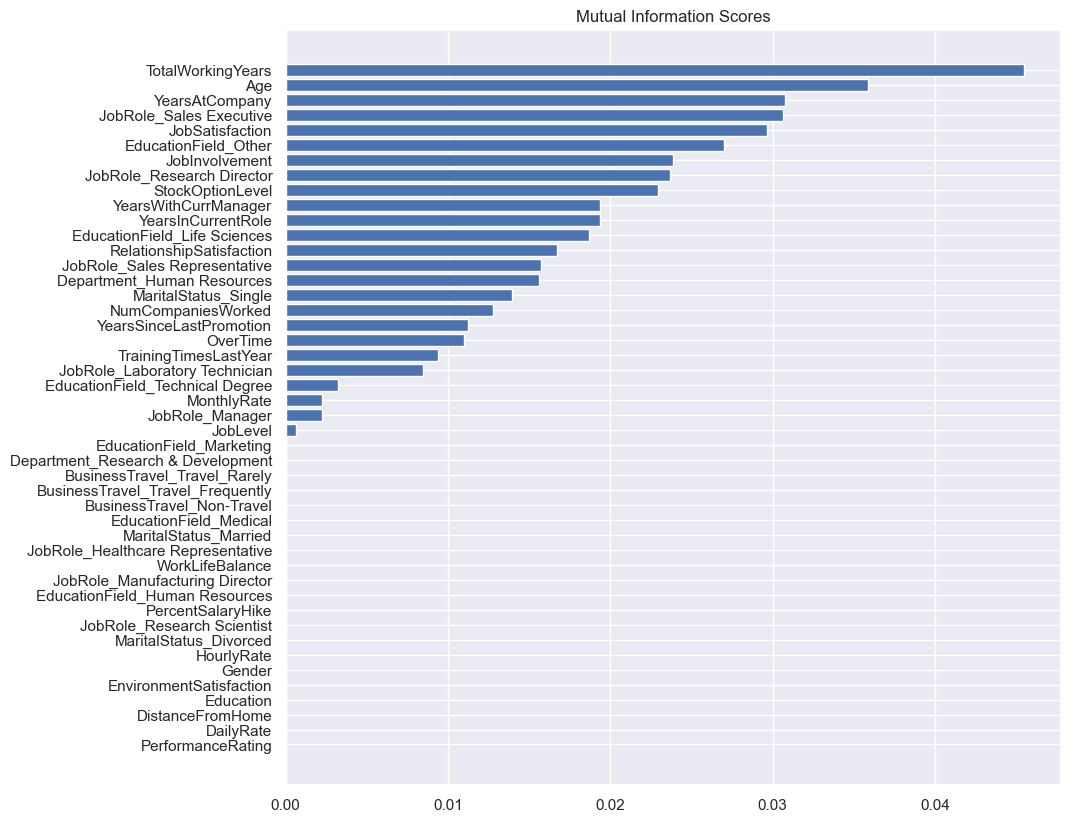

In [62]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores)

In [63]:
to_drop = mi_scores[mi_scores==0].index.tolist()

print('%d columns have been removed' % (len(to_drop)))

X_mi = X.drop(columns = to_drop)
X_mi.head()

21 columns have been removed


,Age,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,...,Department_Human Resources,EducationField_Life Sciences,EducationField_Other,EducationField_Technical Degree,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Research Director,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Single
0,0.547619,0.666667,0.25,1.000000,0.698053,0.888889,1.0,0.000000,0.000000,0.200,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.738095,0.333333,0.25,0.333333,0.916001,0.111111,0.0,1.000000,0.333333,0.250,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.452381,0.333333,0.00,0.666667,0.012126,0.666667,1.0,0.333333,0.000000,0.175,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.357143,0.666667,0.00,0.666667,0.845814,0.111111,1.0,0.666667,0.000000,0.200,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.214286,0.666667,0.00,0.333333,0.583738,1.000000,0.0,1.000000,0.333333,0.150,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(X_mi, y)

Number transactions X dataset:  (1704, 25) (441, 25)
Number transactions y dataset:  (1704,) (441,)
Resampled dataset shape Counter({0.0: 852, 1.0: 852})


In [65]:
# LOGIT

lr3 = LogisticRegression(solver='liblinear')
lr3.fit(X_train, y_train)

print_score(lr3, X_train, y_train, X_test, y_test, train=True)
print_score(lr3, X_train, y_train, X_test, y_test, train=False)
lr3_acc = lr3.score(X_test, y_test)

Train Result:
Accuracy Score: 80.16%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.810386    0.793379  0.801643     0.801883      0.801883
recall       0.787559    0.815728  0.801643     0.801643      0.801643
f1-score     0.798810    0.804398  0.801643     0.801604      0.801604
support    852.000000  852.000000  0.801643  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[671 181]
 [157 695]]

Test Result:
Accuracy Score: 72.11%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.935593   0.287671  0.721088    0.611632      0.845971
recall       0.726316   0.688525  0.721088    0.707420      0.721088
f1-score     0.817778   0.405797  0.721088    0.611787      0.760792
support    380.000000  61.000000  0.721088  441.000000    441.

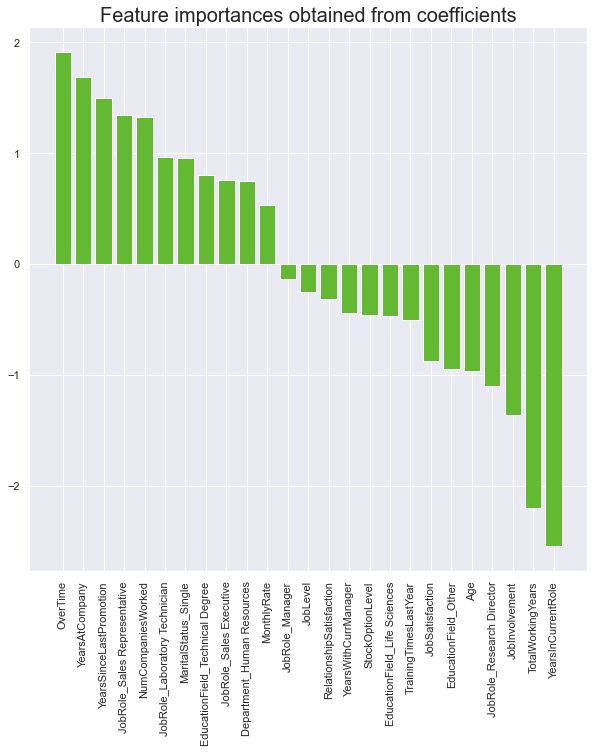

In [66]:
plot_features(lr3, X_train, '#64b932')

In [67]:
# LDA

lda3 = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda3.fit(X_train, y_train)

print_score(lda3, X_train, y_train, X_test, y_test, train=True)
print_score(lda3, X_train, y_train, X_test, y_test, train=False)
lda3_acc = lda3.score(X_test, y_test)

Train Result:
Accuracy Score: 80.40%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.819753    0.789709  0.803991     0.804731      0.804731
recall       0.779343    0.828638  0.803991     0.803991      0.803991
f1-score     0.799037    0.808706  0.803991     0.803871      0.803871
support    852.000000  852.000000  0.803991  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[664 188]
 [146 706]]

Test Result:
Accuracy Score: 72.79%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.942177   0.299320  0.727891    0.620748      0.853256
recall       0.728947   0.721311  0.727891    0.725129      0.727891
f1-score     0.821958   0.423077  0.727891    0.622518      0.766784
support    380.000000  61.000000  0.727891  441.000000    441.

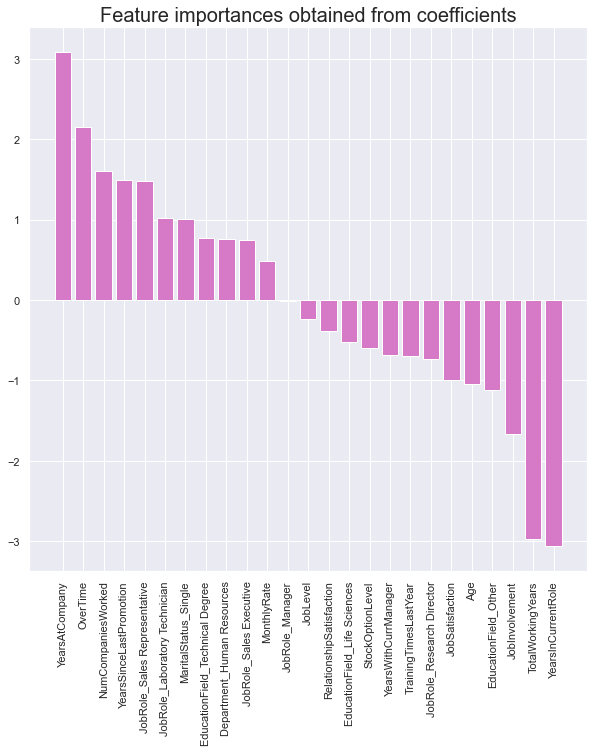

In [68]:
plot_features(lda3, X_train, '#d67ac7')

In [69]:
# NB
nb3 = GaussianNB()
nb3.fit(X_train, y_train)

print_score(nb3, X_train, y_train, X_test, y_test, train=True)
print_score(nb3, X_train, y_train, X_test, y_test, train=False)
nb3_acc = nb3.score(X_test, y_test)

Train Result:
Accuracy Score: 65.67%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.749533    0.614200   0.65669     0.681866      0.681866
recall       0.470657    0.842723   0.65669     0.656690      0.656690
f1-score     0.578226    0.710539   0.65669     0.644383      0.644383
support    852.000000  852.000000   0.65669  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[401 451]
 [134 718]]

Test Result:
Accuracy Score: 48.07%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.921788   0.179389  0.480726    0.550589      0.819098
recall       0.434211   0.770492  0.480726    0.602351      0.480726
f1-score     0.590340   0.291022  0.480726    0.440681      0.548938
support    380.000000  61.000000  0.480726  441.000000    441.

In [70]:
# Multinomial NB
mnb3 = MultinomialNB()
mnb3.fit(X_train, y_train)

print_score(mnb3, X_train, y_train, X_test, y_test, train=True)
print_score(mnb3, X_train, y_train, X_test, y_test, train=False)
mnb3_acc = mnb3.score(X_test, y_test)

Train Result:
Accuracy Score: 74.94%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.770701    0.731230  0.749413     0.750965      0.750965
recall       0.710094    0.788732  0.749413     0.749413      0.749413
f1-score     0.739157    0.758893  0.749413     0.749025      0.749025
support    852.000000  852.000000  0.749413  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[605 247]
 [180 672]]

Test Result:
Accuracy Score: 65.31%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.921933   0.232558  0.653061    0.577246      0.826577
recall       0.652632   0.655738  0.653061    0.654185      0.653061
f1-score     0.764253   0.343348  0.653061    0.553800      0.706032
support    380.000000  61.000000  0.653061  441.000000    441.

In [71]:
cnb3 = ComplementNB()
cnb3.fit(X_train, y_train)

print_score(cnb3, X_train, y_train, X_test, y_test, train=True)
print_score(cnb3, X_train, y_train, X_test, y_test, train=False)
cnb3_acc = cnb3.score(X_test, y_test)

Train Result:
Accuracy Score: 74.94%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.770701    0.731230  0.749413     0.750965      0.750965
recall       0.710094    0.788732  0.749413     0.749413      0.749413
f1-score     0.739157    0.758893  0.749413     0.749025      0.749025
support    852.000000  852.000000  0.749413  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[605 247]
 [180 672]]

Test Result:
Accuracy Score: 65.31%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.921933   0.232558  0.653061    0.577246      0.826577
recall       0.652632   0.655738  0.653061    0.654185      0.653061
f1-score     0.764253   0.343348  0.653061    0.553800      0.706032
support    380.000000  61.000000  0.653061  441.000000    441.

In [72]:
bnb3 = BernoulliNB()
bnb3.fit(X_train, y_train)

print_score(bnb3, X_train, y_train, X_test, y_test, train=True)
print_score(bnb3, X_train, y_train, X_test, y_test, train=False)
bnb3_acc = bnb3.score(X_test, y_test)

Train Result:
Accuracy Score: 75.76%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.754936    0.760380  0.757629     0.757658      0.757658
recall       0.762911    0.752347  0.757629     0.757629      0.757629
f1-score     0.758903    0.756342  0.757629     0.757622      0.757622
support    852.000000  852.000000  0.757629  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[650 202]
 [211 641]]

Test Result:
Accuracy Score: 66.89%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.906250   0.222222  0.668934    0.564236      0.811634
recall       0.686842   0.557377  0.668934    0.622110      0.668934
f1-score     0.781437   0.317757  0.668934    0.549597      0.717300
support    380.000000  61.000000  0.668934  441.000000    441.

In [73]:
# AdaBoost classifier
#abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)
#abc.fit(X_train, y_train)
#
#abc_params = {"learning_rate": [0.05, 0.1, 0.25, 0.5, 0.75, 1],
#              #"max_depth": [1,2,3],
#              "n_estimators": [10,20,30,40,50,60,70,80,90,100],
#              #"subsample": [0.5,0.6,0.7,0.8,0.9],
#              #"min_samples_split": range(10,10),
#              #"min_samples_leaf" : range(15,25),
#              #"max_features":[7,10,13]
#             }
#
#abc_best_grid = GridSearchCV(abc, abc_params, cv=5, n_jobs=-1, verbose=True).fit(X_chi, y)
#abc_best_grid.best_params_

In [74]:
abc3 = AdaBoostClassifier(n_estimators=70, learning_rate=1, random_state=42)
abc3.fit(X_train, y_train)

print_score(abc3, X_train, y_train, X_test, y_test, train=True)
print_score(abc3, X_train, y_train, X_test, y_test, train=False)  #90.24 84.81
abc3_acc = abc3.score(X_test, y_test)

Train Result:
Accuracy Score: 92.14%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0         1.0  accuracy    macro avg  weighted avg
precision    0.912644    0.930456  0.921362     0.921550      0.921550
recall       0.931925    0.910798  0.921362     0.921362      0.921362
f1-score     0.922184    0.920522  0.921362     0.921353      0.921353
support    852.000000  852.000000  0.921362  1704.000000   1704.000000
_______________________________________________
Confusion Matrix: 
 [[794  58]
 [ 76 776]]

Test Result:
Accuracy Score: 83.45%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.909333   0.409091  0.834467    0.659212      0.840139
recall       0.897368   0.442623  0.834467    0.669996      0.834467
f1-score     0.903311   0.425197  0.834467    0.664254      0.837178
support    380.000000  61.000000  0.834467  441.000000    441.

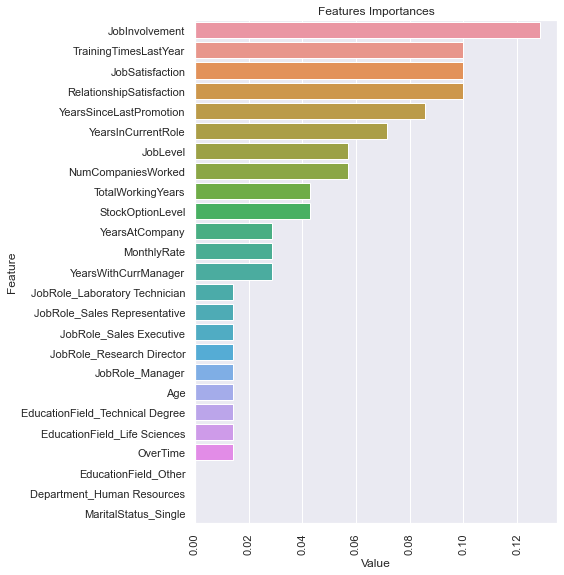

In [75]:
plot_importance(abc3, X_mi)

In [76]:
#bag3 = BaggingClassifier(random_state=42)
#bag3.fit(X_train, y_train)
#
#bag_params = {'n_estimators': [100, 200, 250, 300, 350],
#              'max_features': [0.5, 0.6, 0.75, 0.90, 0.95, 1.0],
#              'bootstrap': [True, False],
#              'bootstrap_features': [True, False],}
#
#bag_best_grid = GridSearchCV(bag2, bag_params, cv=5, n_jobs=-1, verbose=True).fit(X_chi, y)
#bag_best_grid.best_params_

In [77]:
bag3 = BaggingClassifier(n_estimators=100, max_features=0.60, bootstrap_features=False, bootstrap=True, random_state=42)
bag3.fit(X_train, y_train)

print_score(bag3, X_train, y_train, X_test, y_test, train=True)
print_score(bag3, X_train, y_train, X_test, y_test, train=False) # 100    86.62
bag3_acc = bag3.score(X_test, y_test)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
             0.0    1.0  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    852.0  852.0       1.0     1704.0        1704.0
_______________________________________________
Confusion Matrix: 
 [[852   0]
 [  0 852]]

Test Result:
Accuracy Score: 85.26%
_______________________________________________
CLASSIFICATION REPORT:
                  0.0        1.0  accuracy   macro avg  weighted avg
precision    0.877698   0.416667  0.852608    0.647182      0.813927
recall       0.963158   0.163934  0.852608    0.563546      0.852608
f1-score     0.918444   0.235294  0.852608    0.576869      0.823949
support    380.000000  61.000000  0.852608  441.000000    441.000000
_______________________________________________
Conf

In [78]:
mi_acc = [lr3_acc, lda3_acc, nb3_acc, mnb3_acc, cnb3_acc, bnb3_acc, abc3_acc, bag3_acc]
acc_df['MI Score'] = mi_acc
acc_df

,All Variables,ChiSquared,MI Score
Logistic Regression,0.768707,0.671202,0.721088
Linear Disciriminant Analysis,0.759637,0.671202,0.727891
Naive Bayes,0.560091,0.798186,0.480726
Multinomial NB,0.673469,0.691610,0.653061
Complement NB,0.673469,0.691610,0.653061
Bernouilli NB,0.721088,0.730159,0.668934
AdaBoost,0.873016,0.723356,0.834467
Bagging,0.879819,0.759637,0.852608


### 8. Multivariate Wrapper Feature Subset Selection

In [79]:
# re defining the orginal train and test
X_train, X_test, y_train, y_test = splitting_train_test_smote(X, y)

Number transactions X dataset:  (1706, 46) (441, 46)
Number transactions y dataset:  (1706,) (441,)
Resampled dataset shape Counter({0.0: 853, 1.0: 853})


In [80]:
lr3 = LogisticRegression(solver='liblinear')

lr3 = SFS(lr3, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)

lr3_fit = lr3.fit(X, y)
pd.DataFrame.from_dict(lr3_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    3.2s finished

[2022-11-22 22:07:38] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:38] Features: 2/5 -- score: 0.8442176870748299[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  44 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:38] Features: 3/5 -- score: 0.8489795918367347[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.0s fi

,1,2,3,4,5
feature_idx,"(0,)","(0, 12)","(0, 12, 23)","(0, 4, 12, 23)","(0, 4, 12, 17, 23)"
cv_scores,[0.8387755102040816],[0.8442176870748299],[0.8489795918367347],[0.8510204081632653],[0.8551020408163266]
avg_score,0.838776,0.844218,0.84898,0.85102,0.855102
feature_names,"(Age,)","(Age, OverTime)","(Age, OverTime, YearsWithCurrManager)","(Age, EnvironmentSatisfaction, OverTime, Years...","(Age, EnvironmentSatisfaction, OverTime, Total..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [81]:
lr_x = X.iloc[:,list(lr3_fit.k_feature_idx_)]
lr_x.head()

,Age,EnvironmentSatisfaction,OverTime,TotalWorkingYears,YearsWithCurrManager
0,0.547619,0.333333,1.0,0.200,0.294118
1,0.738095,0.666667,0.0,0.250,0.411765
2,0.452381,1.000000,1.0,0.175,0.000000
3,0.357143,1.000000,1.0,0.200,0.000000
4,0.214286,0.000000,0.0,0.150,0.117647


In [82]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(lr_x, y)

Number transactions X dataset:  (1614, 5) (441, 5)
Number transactions y dataset:  (1614,) (441,)
Resampled dataset shape Counter({0.0: 807, 1.0: 807})


In [83]:
lr4 = LogisticRegression(solver='liblinear')
lr4.fit(X_train, y_train)

y_pred = lr4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

lr4_acc =  lr4.score(X_test, y_test)
print('LR accuracy: ', lr4_acc)

[[282  98]
 [ 26  35]]
              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82       380
         1.0       0.26      0.57      0.36        61

    accuracy                           0.72       441
   macro avg       0.59      0.66      0.59       441
weighted avg       0.83      0.72      0.76       441

LR accuracy:  0.7188208616780045


In [84]:
lda4 = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')

lda4 = SFS(lda4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)

lda4_fit = lda4.fit(X, y)
pd.DataFrame.from_dict(lda4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  46 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.0s finished

[2022-11-22 22:07:39] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:39] Features: 2/5 -- score: 0.8462585034013606[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  44 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:39] Features: 3/5 -- score: 0.8510204081632653[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | 

,1,2,3,4,5
feature_idx,"(0,)","(0, 12)","(0, 12, 23)","(0, 2, 12, 23)","(0, 2, 12, 23, 31)"
cv_scores,[0.8387755102040816],[0.8462585034013606],[0.8510204081632653],[0.8571428571428571],[0.8612244897959184]
avg_score,0.838776,0.846259,0.85102,0.857143,0.861224
feature_names,"(Age,)","(Age, OverTime)","(Age, OverTime, YearsWithCurrManager)","(Age, DistanceFromHome, OverTime, YearsWithCur...","(Age, DistanceFromHome, OverTime, YearsWithCur..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [85]:
lda_x = X.iloc[:,list(lda4_fit.k_feature_idx_)]
lda_x.head()

,Age,DistanceFromHome,OverTime,YearsWithCurrManager,EducationField_Marketing
0,0.547619,0.000000,1.0,0.294118,0.0
1,0.738095,0.250000,0.0,0.411765,0.0
2,0.452381,0.035714,1.0,0.000000,0.0
3,0.357143,0.071429,1.0,0.000000,0.0
4,0.214286,0.035714,0.0,0.117647,0.0


In [86]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(lda_x, y)

Number transactions X dataset:  (1612, 5) (441, 5)
Number transactions y dataset:  (1612,) (441,)
Resampled dataset shape Counter({0.0: 806, 1.0: 806})


In [87]:
lda4 = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda4.fit(X_train, y_train)

y_pred = lda4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

lda4_acc =  lda4.score(X_test, y_test)
print('LDA accuracy: ', lda4_acc)

[[278 102]
 [ 25  36]]
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81       380
         1.0       0.26      0.59      0.36        61

    accuracy                           0.71       441
   macro avg       0.59      0.66      0.59       441
weighted avg       0.83      0.71      0.75       441

LDA accuracy:  0.7120181405895691


In [88]:
nb4 = GaussianNB()
nb4 = SFS(nb4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)

nb4_fit = nb4.fit(X, y)
pd.DataFrame.from_dict(nb4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.0s finished

[2022-11-22 22:07:39] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 2/5 -- score: 0.8462585034013606[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 3/5 -- score: 0.8530612244897959[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  43 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 4/5 -- score: 0.855102

,1,2,3,4,5
feature_idx,"(0,)","(0, 12)","(0, 12, 45)","(0, 3, 12, 45)","(0, 3, 5, 12, 45)"
cv_scores,[0.8387755102040816],[0.8462585034013606],[0.8530612244897959],[0.8551020408163266],[0.85578231292517]
avg_score,0.838776,0.846259,0.853061,0.855102,0.855782
feature_names,"(Age,)","(Age, OverTime)","(Age, OverTime, MaritalStatus_Single)","(Age, Education, OverTime, MaritalStatus_Single)","(Age, Education, Gender, OverTime, MaritalStat..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [89]:
nb4_x = X.iloc[:,list(nb4_fit.k_feature_idx_)]
nb4_x.head()

,Age,Education,Gender,OverTime,MaritalStatus_Single
0,0.547619,0.25,0.0,1.0,1.0
1,0.738095,0.00,1.0,0.0,0.0
2,0.452381,0.25,1.0,1.0,1.0
3,0.357143,0.75,0.0,1.0,0.0
4,0.214286,0.00,1.0,0.0,0.0


In [90]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(nb4_x, y)

Number transactions X dataset:  (1620, 5) (441, 5)
Number transactions y dataset:  (1620,) (441,)
Resampled dataset shape Counter({0.0: 810, 1.0: 810})


In [91]:
nb4 = GaussianNB()
nb4.fit(X_train, y_train)

y_pred = nb4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

nb4_acc =  nb4.score(X_test, y_test)
print('LDA accuracy: ', nb4_acc)

[[242 138]
 [ 24  37]]
              precision    recall  f1-score   support

         0.0       0.91      0.64      0.75       380
         1.0       0.21      0.61      0.31        61

    accuracy                           0.63       441
   macro avg       0.56      0.62      0.53       441
weighted avg       0.81      0.63      0.69       441

LDA accuracy:  0.6326530612244898


In [92]:
mnb4 = MultinomialNB()
mnb4 = SFS(mnb4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)

mnb4_fit = mnb4.fit(X, y)
pd.DataFrame.from_dict(mnb4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 2/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 3/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.0s finished

[2022-11-22 22:07:40] Features: 4/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.0s finished

[202

,1,2,3,4,5
feature_idx,"(0,)","(0, 1)","(0, 1, 2)","(0, 1, 2, 3)","(0, 1, 2, 3, 4)"
cv_scores,[0.8387755102040816],[0.8387755102040816],[0.8387755102040816],[0.8387755102040816],[0.8387755102040816]
avg_score,0.838776,0.838776,0.838776,0.838776,0.838776
feature_names,"(Age,)","(Age, DailyRate)","(Age, DailyRate, DistanceFromHome)","(Age, DailyRate, DistanceFromHome, Education)","(Age, DailyRate, DistanceFromHome, Education, ..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [93]:
mnb4_x = X.iloc[:,list(mnb4_fit.k_feature_idx_)]
mnb4_x.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction
0,0.547619,0.715820,0.000000,0.25,0.333333
1,0.738095,0.126700,0.250000,0.00,0.666667
2,0.452381,0.909807,0.035714,0.25,1.000000
3,0.357143,0.923407,0.071429,0.75,1.000000
4,0.214286,0.350036,0.035714,0.00,0.000000


In [94]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(mnb4_x, y)

Number transactions X dataset:  (1654, 5) (441, 5)
Number transactions y dataset:  (1654,) (441,)
Resampled dataset shape Counter({0.0: 827, 1.0: 827})


In [95]:
mnb4 = MultinomialNB()
mnb4.fit(X_train, y_train)

y_pred = mnb4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

mnb4_acc =  mnb4.score(X_test, y_test)
print('MNB accuracy: ', mnb4_acc)

[[257 123]
 [ 26  35]]
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78       380
         1.0       0.22      0.57      0.32        61

    accuracy                           0.66       441
   macro avg       0.56      0.63      0.55       441
weighted avg       0.81      0.66      0.71       441

MNB accuracy:  0.6621315192743764


In [96]:
cnb4 = ComplementNB()
cnb4 = SFS(cnb4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)

cnb4_fit = cnb4.fit(X, y)
pd.DataFrame.from_dict(cnb4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.0s finished

[2022-11-22 22:07:41] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:41] Features: 2/5 -- score: 0.8299319727891157[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  44 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:41] Features: 3/5 -- score: 0.8299319727891157[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  43 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | 

,1,2,3,4,5
feature_idx,"(0,)","(0, 29)","(0, 4, 29)","(0, 4, 28, 29)","(0, 4, 9, 28, 29)"
cv_scores,[0.8387755102040816],[0.8299319727891157],[0.8299319727891157],[0.8306122448979592],[0.8312925170068027]
avg_score,0.838776,0.829932,0.829932,0.830612,0.831293
feature_names,"(Age,)","(Age, EducationField_Human Resources)","(Age, EnvironmentSatisfaction, EducationField_...","(Age, EnvironmentSatisfaction, Department_Rese...","(Age, EnvironmentSatisfaction, JobSatisfaction..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [97]:
cnb4_x = X.iloc[:,list(cnb4_fit.k_feature_idx_)]
cnb4_x.head()

,Age,EnvironmentSatisfaction,JobSatisfaction,Department_Research & Development,EducationField_Human Resources
0,0.547619,0.333333,1.000000,0.0,0.0
1,0.738095,0.666667,0.333333,1.0,0.0
2,0.452381,1.000000,0.666667,1.0,0.0
3,0.357143,1.000000,0.666667,1.0,0.0
4,0.214286,0.000000,0.333333,1.0,0.0


In [98]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(cnb4_x, y)

Number transactions X dataset:  (1604, 5) (441, 5)
Number transactions y dataset:  (1604,) (441,)
Resampled dataset shape Counter({0.0: 802, 1.0: 802})


In [99]:
cnb4 = ComplementNB()
cnb4.fit(X_train, y_train)

y_pred = cnb4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cnb4_acc =  cnb4.score(X_test, y_test)
print('MNB accuracy: ', cnb4_acc)

[[264 116]
 [ 42  19]]
              precision    recall  f1-score   support

         0.0       0.86      0.69      0.77       380
         1.0       0.14      0.31      0.19        61

    accuracy                           0.64       441
   macro avg       0.50      0.50      0.48       441
weighted avg       0.76      0.64      0.69       441

MNB accuracy:  0.6417233560090703


In [100]:
bnb4 = BernoulliNB()
bnb4 = SFS(bnb4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)

bnb4_fit = bnb4.fit(X, y)
pd.DataFrame.from_dict(bnb4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.0s finished

[2022-11-22 22:07:41] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 2/5 -- score: 0.8401360544217688[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  44 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 3/5 -- score: 0.8401360544217688[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  43 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 4/5 -- score: 0.840136

,1,2,3,4,5
feature_idx,"(0,)","(0, 5)","(0, 1, 5)","(0, 1, 2, 5)","(0, 1, 2, 3, 5)"
cv_scores,[0.8387755102040816],[0.8401360544217688],[0.8401360544217688],[0.8401360544217688],[0.8401360544217688]
avg_score,0.838776,0.840136,0.840136,0.840136,0.840136
feature_names,"(Age,)","(Age, Gender)","(Age, DailyRate, Gender)","(Age, DailyRate, DistanceFromHome, Gender)","(Age, DailyRate, DistanceFromHome, Education, ..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [101]:
bnb4_x = X.iloc[:,list(bnb4_fit.k_feature_idx_)]
bnb4_x.head()

,Age,DailyRate,DistanceFromHome,Education,Gender
0,0.547619,0.715820,0.000000,0.25,0.0
1,0.738095,0.126700,0.250000,0.00,1.0
2,0.452381,0.909807,0.035714,0.25,1.0
3,0.357143,0.923407,0.071429,0.75,0.0
4,0.214286,0.350036,0.035714,0.00,1.0


In [102]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(bnb4_x, y)

Number transactions X dataset:  (1624, 5) (441, 5)
Number transactions y dataset:  (1624,) (441,)
Resampled dataset shape Counter({0.0: 812, 1.0: 812})


In [103]:
bnb4 = BernoulliNB()
bnb4.fit(X_train, y_train)

y_pred = bnb4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

bnb4_acc =  bnb4.score(X_test, y_test)
print('BNB accuracy: ', bnb4_acc)

[[201 179]
 [ 30  31]]
              precision    recall  f1-score   support

         0.0       0.87      0.53      0.66       380
         1.0       0.15      0.51      0.23        61

    accuracy                           0.53       441
   macro avg       0.51      0.52      0.44       441
weighted avg       0.77      0.53      0.60       441

BNB accuracy:  0.5260770975056689


In [104]:
abc4 = AdaBoostClassifier(n_estimators=40, learning_rate=0.75, random_state=42)
abc4 = SFS(nb4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)
abc4_fit = abc4.fit(X, y)
pd.DataFrame.from_dict(abc4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 1/5 -- score: 0.8387755102040816[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 2/5 -- score: 0.8462585034013606[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  44 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 3/5 -- score: 0.8530612244897959[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.0s finished

[2022-11-22 22:07:42] Features: 4/5 -- score: 0.855102

,1,2,3,4,5
feature_idx,"(0,)","(0, 12)","(0, 12, 45)","(0, 3, 12, 45)","(0, 3, 5, 12, 45)"
cv_scores,[0.8387755102040816],[0.8462585034013606],[0.8530612244897959],[0.8551020408163266],[0.85578231292517]
avg_score,0.838776,0.846259,0.853061,0.855102,0.855782
feature_names,"(Age,)","(Age, OverTime)","(Age, OverTime, MaritalStatus_Single)","(Age, Education, OverTime, MaritalStatus_Single)","(Age, Education, Gender, OverTime, MaritalStat..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [105]:
abc4_x = X.iloc[:,list(abc4_fit.k_feature_idx_)]
abc4_x.head()

,Age,Education,Gender,OverTime,MaritalStatus_Single
0,0.547619,0.25,0.0,1.0,1.0
1,0.738095,0.00,1.0,0.0,0.0
2,0.452381,0.25,1.0,1.0,1.0
3,0.357143,0.75,0.0,1.0,0.0
4,0.214286,0.00,1.0,0.0,0.0


In [106]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(abc4_x, y)

Number transactions X dataset:  (1620, 5) (441, 5)
Number transactions y dataset:  (1620,) (441,)
Resampled dataset shape Counter({0.0: 810, 1.0: 810})


In [107]:
abc4 = AdaBoostClassifier(n_estimators=40, learning_rate=0.75, random_state=42)
abc4.fit(X_train, y_train)

y_pred = abc4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

abc4_acc =  abc4.score(X_test, y_test)
print('ABC accuracy: ', abc4_acc)

[[269 111]
 [ 29  32]]
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79       380
         1.0       0.22      0.52      0.31        61

    accuracy                           0.68       441
   macro avg       0.56      0.62      0.55       441
weighted avg       0.81      0.68      0.73       441

ABC accuracy:  0.6825396825396826


In [108]:
bag4 = BaggingClassifier(n_estimators=350, max_features=1.0, bootstrap_features=False, bootstrap=True, random_state=42)
bag4 = SFS(bag4, k_features=5, forward=True, floating=False, verbose=2, scoring='accuracy', n_jobs=-1, cv=0)
bag4_fit = bag4.fit(X, y)
pd.DataFrame.from_dict(bag4_fit.get_metric_dict())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   14.9s finished

[2022-11-22 22:07:58] Features: 1/5 -- score: 0.9884353741496599[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   26.1s finished

[2022-11-22 22:08:24] Features: 2/5 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   28.6s finished

[2022-11-22 22:08:53] Features: 3/5 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   27.9s finished

,1,2,3,4,5
feature_idx,"(10,)","(1, 10)","(0, 1, 10)","(0, 1, 2, 10)","(0, 1, 2, 3, 10)"
cv_scores,[0.9884353741496599],[1.0],[1.0],[1.0],[1.0]
avg_score,0.988435,1,1,1,1
feature_names,"(MonthlyRate,)","(DailyRate, MonthlyRate)","(Age, DailyRate, MonthlyRate)","(Age, DailyRate, DistanceFromHome, MonthlyRate)","(Age, DailyRate, DistanceFromHome, Education, ..."
ci_bound,NaN,NaN,NaN,NaN,NaN
std_dev,0,0,0,0,0
std_err,NaN,NaN,NaN,NaN,NaN


In [109]:
bag4_x = X.iloc[:,list(bag4_fit.k_feature_idx_)]
bag4_x.head()

,Age,DailyRate,DistanceFromHome,Education,MonthlyRate
0,0.547619,0.715820,0.000000,0.25,0.698053
1,0.738095,0.126700,0.250000,0.00,0.916001
2,0.452381,0.909807,0.035714,0.25,0.012126
3,0.357143,0.923407,0.071429,0.75,0.845814
4,0.214286,0.350036,0.035714,0.00,0.583738


In [110]:
X_train, X_test, y_train, y_test = splitting_train_test_smote(bag4_x, y)

Number transactions X dataset:  (1668, 5) (441, 5)
Number transactions y dataset:  (1668,) (441,)
Resampled dataset shape Counter({0.0: 834, 1.0: 834})


In [111]:
bag4 = BaggingClassifier(n_estimators=350, max_features=1.0, bootstrap_features=False, bootstrap=True, random_state=42)
bag4.fit(X_train, y_train)

y_pred = bag4.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

bag4_acc =  bag4.score(X_test, y_test)
print('ABC accuracy: ', bag4_acc)

[[318  62]
 [ 49  12]]
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       380
         1.0       0.16      0.20      0.18        61

    accuracy                           0.75       441
   macro avg       0.51      0.52      0.51       441
weighted avg       0.77      0.75      0.76       441

ABC accuracy:  0.7482993197278912


In [112]:
sfs_acc = [lr4_acc, lda4_acc, nb4_acc, mnb4_acc, cnb4_acc, bnb4_acc, abc4_acc, bag4_acc]
acc_df['SFS Method'] = sfs_acc
acc_df

,All Variables,ChiSquared,MI Score,SFS Method
Logistic Regression,0.768707,0.671202,0.721088,0.718821
Linear Disciriminant Analysis,0.759637,0.671202,0.727891,0.712018
Naive Bayes,0.560091,0.798186,0.480726,0.632653
Multinomial NB,0.673469,0.691610,0.653061,0.662132
Complement NB,0.673469,0.691610,0.653061,0.641723
Bernouilli NB,0.721088,0.730159,0.668934,0.526077
AdaBoost,0.873016,0.723356,0.834467,0.682540
Bagging,0.879819,0.759637,0.852608,0.748299
